In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [2]:
image = cv2.imread('C:/ImageProcessing/labs/Segmentation/sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

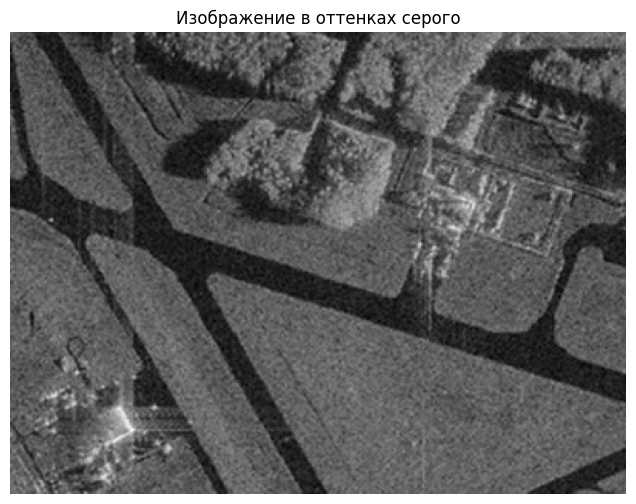

In [3]:
plt.figure(figsize=(8, 6))
plt.imshow(image_gray, cmap='gray')
plt.title('Изображение в оттенках серого')
plt.axis('off')
plt.show()

In [4]:
def homo_average(img, mask, point, T):
    if np.count_nonzero(mask > 0) == 0:
        return False
    av_val = img[mask > 0].sum() / np.count_nonzero(mask > 0)
    if abs(av_val - img[point]) <= T:
        return True
    return False

In [5]:
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i,j] == 0 and mask[i-r:i+r+1, j-r:j+r+1].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255

In [6]:
seed_point = (250, 250)

In [7]:
mask = region_growing(image_gray, seed_point, homo_average, 1, 20)

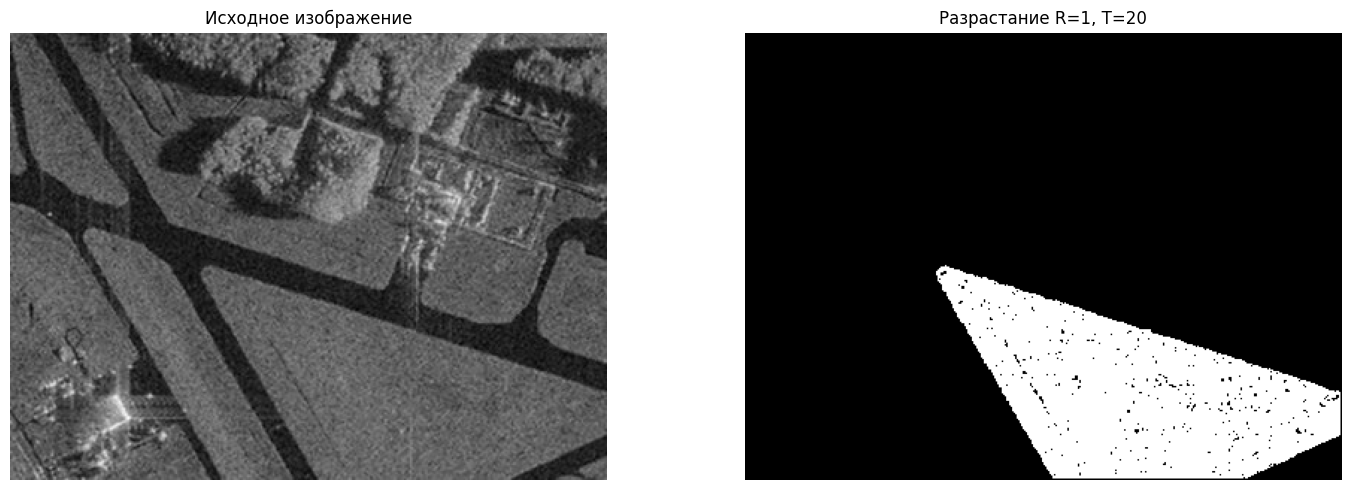

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Разрастание R=1, T=20')
plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
z = image_gray.reshape((-1,3))
z = np.float32(z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

In [10]:
def homo_median(img, mask, point, T):
    # Безопасная версия с обработкой ошибок
    try:
        masked_pixels = img[mask > 0]
        if len(masked_pixels) == 0:
            return False
        
        median_val = np.median(masked_pixels)
        return abs(median_val - img[point]) <= T
    except Exception as e:
        print(f"Ошибка в homo_median: {e}")
        return False

In [11]:
new_mask = region_growing(image_gray, seed_point, homo_median, 1, 20)   

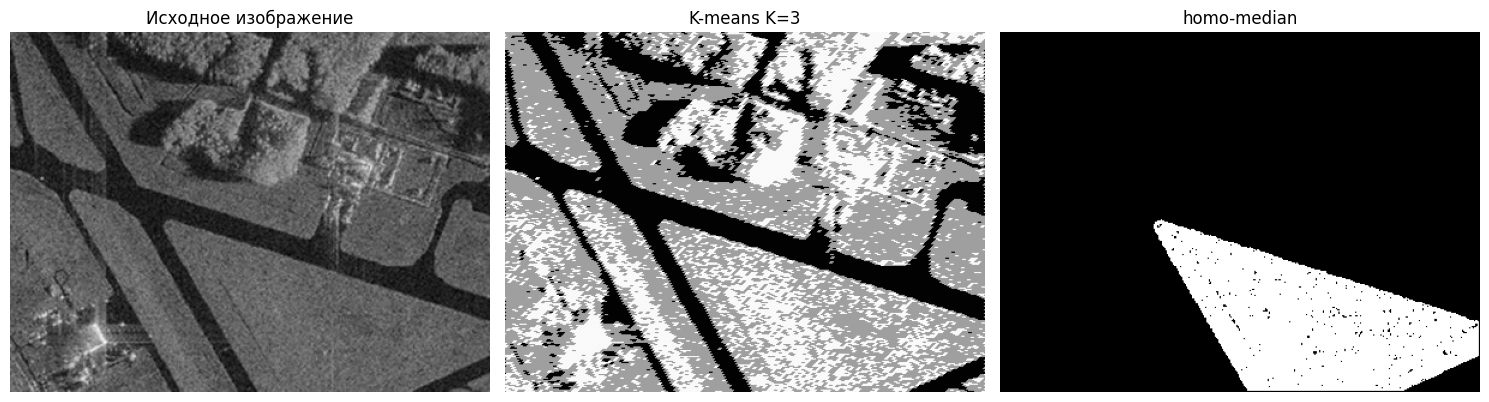

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(res2, cmap='gray')
plt.title('K-means K=3')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(new_mask, cmap='gray')
plt.title('homo-median')
plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
img = cv2.imread('C:/ImageProcessing/labs/Segmentation/palm_1.JPG')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

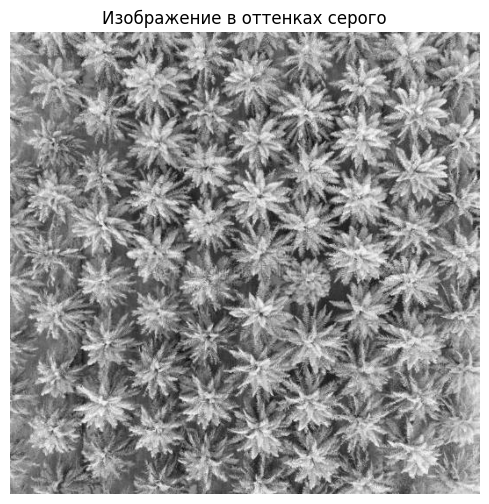

In [14]:
plt.figure(figsize=(8, 6))
plt.imshow(img_gray, cmap='gray')
plt.title('Изображение в оттенках серого')
plt.axis('off')
plt.show()

In [15]:
blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

ret, markers = cv2.connectedComponents(sure_fg)
markers = cv2.watershed(img, markers)
count = len(np.unique(markers)) - 1

print(f"Найдено пальмовых деревьев: {count}")

Найдено пальмовых деревьев: 228


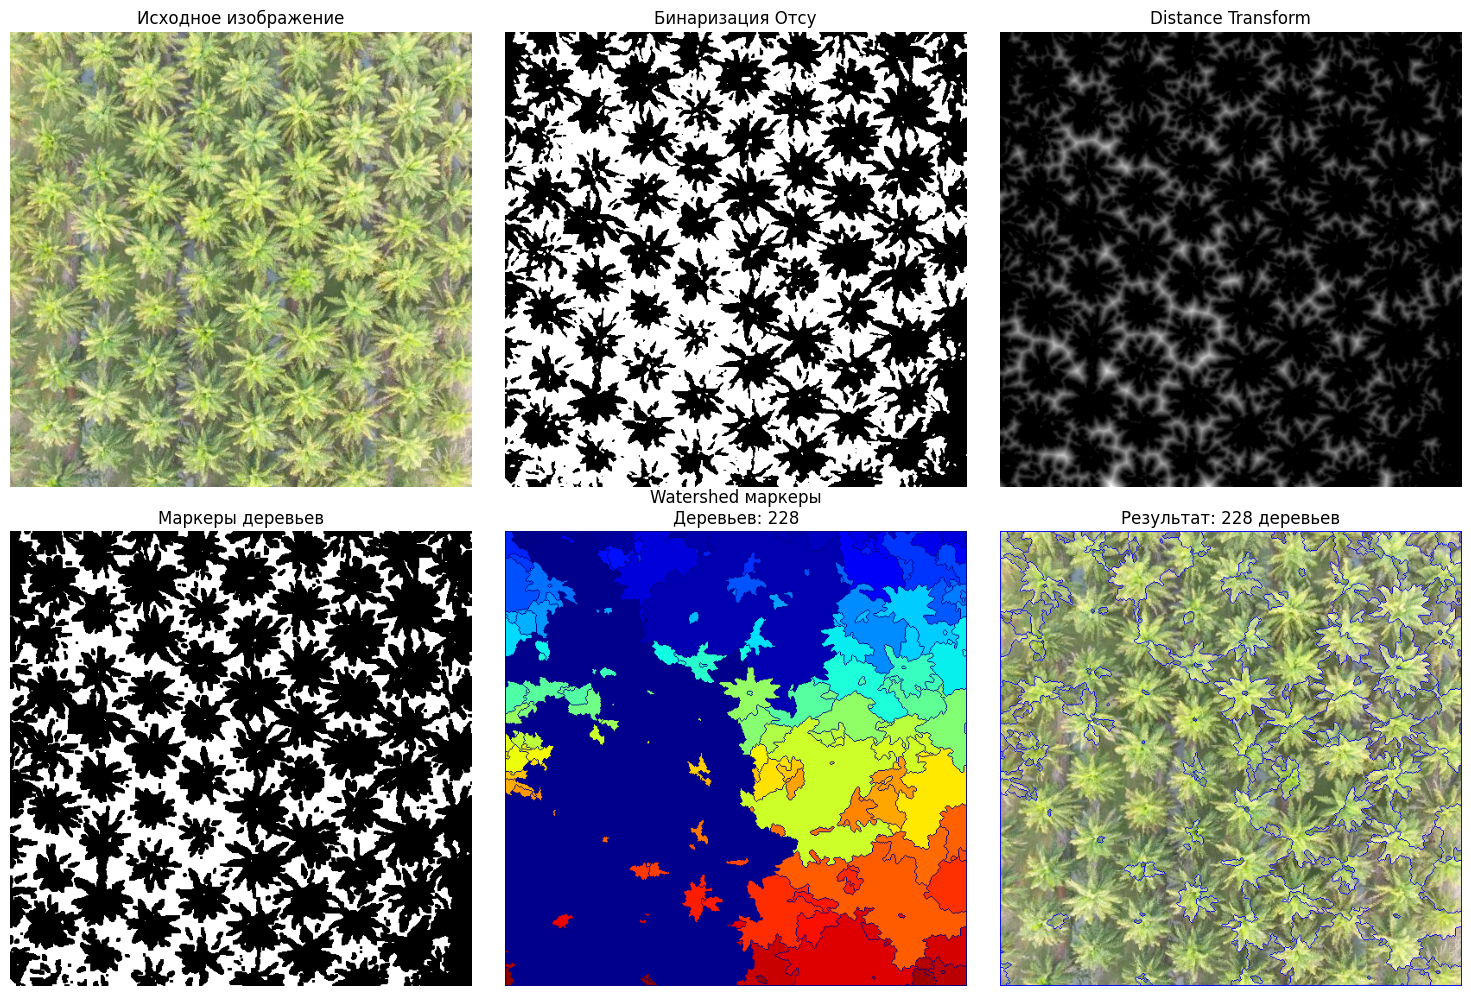

In [16]:
# Визуализация всех этапов
plt.figure(figsize=(15, 10))

# Исходное изображение
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Исходное изображение')
plt.axis('off')

# Бинаризация Отсу
plt.subplot(2, 3, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Бинаризация Отсу')
plt.axis('off')

# Distance Transform
plt.subplot(2, 3, 3)
plt.imshow(dist, cmap='gray')
plt.title('Distance Transform')
plt.axis('off')

# Маркеры
plt.subplot(2, 3, 4)
plt.imshow(sure_fg, cmap='gray')
plt.title('Маркеры деревьев')
plt.axis('off')

# Watershed маркеры
plt.subplot(2, 3, 5)
plt.imshow(markers, cmap='jet')
plt.title(f'Watershed маркеры\nДеревьев: {count}')
plt.axis('off')

# Результат на исходном изображении
result_img = img.copy()
result_img[markers == -1] = [255, 0, 0]

plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title(f'Результат: {count} деревьев')
plt.axis('off')

plt.tight_layout()
plt.show()